# US Market Stress 
Author: Sil (sil@bayes.org)

Date: 2020-06-22

We are pursuing our efforts in assessing the availability of the data needed to implement Bob for US residents.

Here, we woud like to know if we are able to get estimates of the US [market stress](https://docs.google.com/document/d/1t5-rgJDLUanYl-y_4z1-MGiHyhakq4FsViJN9bOiLe4/edit#) and how fine grain these estimates would be.
The Bureau of Labor Statistics (BLS) of the U.S. Department of Labor is the principal federal agency responsible for measuring labor market activity, working conditions, and price changes in the economy. They provide several datasets among them we are interested in, [projected employment](https://projectionscentral.com/Projections/AboutLT) and [currently occupied jobs](https://www.bls.gov/oes/home.htm). The Department of Labor also provides [Unemployment Insurance Data](https://oui.doleta.gov/unemploy/DataDashboard.asp).

Data can be obtain with:
```
make data/usa/employment_projections_short_term.xlsx
make data/usa/occupational_employment_state_statistics.xlsx
make data/usa/unemployment_insurance_claimants.csv
```

Let's start the exploration!

## Data Uploading

In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set()

DATA_FOLDER = os.getenv('DATA_FOLDER')

projections = pd.read_excel(os.path.join(
    DATA_FOLDER, 'usa/employment_projections_short_term.xlsx'))
occupations = pd.read_excel(os.path.join(
    DATA_FOLDER, 'usa/occupational_employment_state_statistics.xlsx'))
job_seekers = pd.read_csv(os.path.join(
    DATA_FOLDER, 'usa/unemployment_insurance_claimants.csv'),
    parse_dates=['rptdate'])
display(projections.head())
display(occupations.head())
job_seekers.head()

,State FIPS,Area Name,Occupation Code,Occupation Name,Base Year,Base,Projected Year,Projection,Change,Percent Change,Average Annual Openings
0,1,Alabama,00-0000,"Total, All Occupations",2019,2198090,2021,2252990,54900,2.5,284240
1,1,Alabama,11-1011,Chief Executives,2019,1910,2021,1920,10,0.5,140
2,1,Alabama,11-1021,General and Operations Managers,2019,29040,2021,30000,960,3.3,3040
3,1,Alabama,11-1031,Legislators,2019,1270,2021,1290,20,1.6,110
4,1,Alabama,11-2011,Advertising and Promotions Managers,2019,70,2021,70,0,0.0,10


,area,area_title,area_type,naics,naics_title,i_group,own_code,occ_code,occ_title,o_group,...,h_median,h_pct75,h_pct90,a_pct10,a_pct25,a_median,a_pct75,a_pct90,annual,hourly
0,1,Alabama,2,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,total,...,16.73,26.34,39.26,18270,23000,34800,54790,81660,NaN,NaN
1,1,Alabama,2,0,Cross-industry,cross-industry,1235,11-0000,Management Occupations,major,...,45.03,63.07,90.16,47250,66140,93660,131180,187530,NaN,NaN
2,1,Alabama,2,0,Cross-industry,cross-industry,1235,11-1011,Chief Executives,detailed,...,86.91,#,#,68630,115110,180780,#,#,NaN,NaN
3,1,Alabama,2,0,Cross-industry,cross-industry,1235,11-1021,General and Operations Managers,detailed,...,47.42,70.48,#,48240,66370,98630,146610,#,NaN,NaN
4,1,Alabama,2,0,Cross-industry,cross-industry,1235,11-1031,Legislators,detailed,...,*,*,*,16200,17210,18880,28660,55220,True,NaN


,st,rptdate,c1,c2,c3,c4,c12,c13,c14,c15,...,c84,c85,c86,c87,c88,c89,c90,c91,c92,c93
0,AK,1994-08-31,P,4388,4554,0,343,527,2697,2907,...,0,0,0,0,0,0,0,0,0,0
1,AK,1994-09-30,P,4523,4187,0,325,541,2718,2796,...,0,0,0,0,0,0,0,0,0,0
2,AK,1994-10-31,P,5456,4388,0,309,636,3109,3201,...,0,0,0,0,0,0,0,0,0,0
3,AK,1994-11-30,P,7869,5094,0,451,834,4174,4196,...,0,0,0,0,0,0,0,0,0,0
4,AK,1994-12-31,P,8945,4602,0,502,838,4264,4382,...,0,0,0,0,0,0,0,0,0,0


OK!
- The projections dataset is quite straightforward. We might be interested in the annual openings and/or the number of projected jobs.
- There are a lot of data in the occupations dataset. Some data seems to be missing (e.g. "#" and "\*").
- We might need a [data map](https://oui.doleta.gov/dmstree/handbooks/402/402_4/4024c6/4024c6.pdf#ETA203) to navigate the unemployment insurance claims dataset.


## First insights

Let's reformat the job seekers dataset.

In [2]:
# The IUD data map has been manually created from 
# https://oui.doleta.gov/dmstree/handbooks/402/402_4/4024c6/4024c6.pdf#ETA203
iud_data_map = pd.read_csv(os.path.join(
    DATA_FOLDER, 'usa/iud_occupations_map.csv'),
    comment='#')
# The crosswalk between states abbreviations and names has been manually created
# from https://www.50states.com/abbreviations.htm
states_map = pd.read_csv(os.path.join(
    DATA_FOLDER, 'usa/states_map.csv'),
    comment='#')
states_map.set_index('Abbreviation', inplace=True)
job_seekers['state'] = job_seekers['st'].map(states_map.US_State)
occupations_map = iud_data_map.set_index('Internal_code')['SOC'].\
    to_dict()
job_seekers.rename(columns=occupations_map, inplace=True)
job_seekers.head()

,st,rptdate,c1,c2,c3,c4,c12,c13,c14,c15,...,41-0000,43-0000,45-0000,47-0000,49-0000,51-0000,53-0000,55-0000,NaN,state
0,AK,1994-08-31,P,4388,4554,0,343,527,2697,2907,...,0,0,0,0,0,0,0,0,0,Alaska
1,AK,1994-09-30,P,4523,4187,0,325,541,2718,2796,...,0,0,0,0,0,0,0,0,0,Alaska
2,AK,1994-10-31,P,5456,4388,0,309,636,3109,3201,...,0,0,0,0,0,0,0,0,0,Alaska
3,AK,1994-11-30,P,7869,5094,0,451,834,4174,4196,...,0,0,0,0,0,0,0,0,0,Alaska
4,AK,1994-12-31,P,8945,4602,0,502,838,4264,4382,...,0,0,0,0,0,0,0,0,0,Alaska


It sounds OK. 
However, some reports seem to be quite old. Let's explore this dataset.

### Job Seekers Insurance Claims

First, what is the date range of these reports?

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


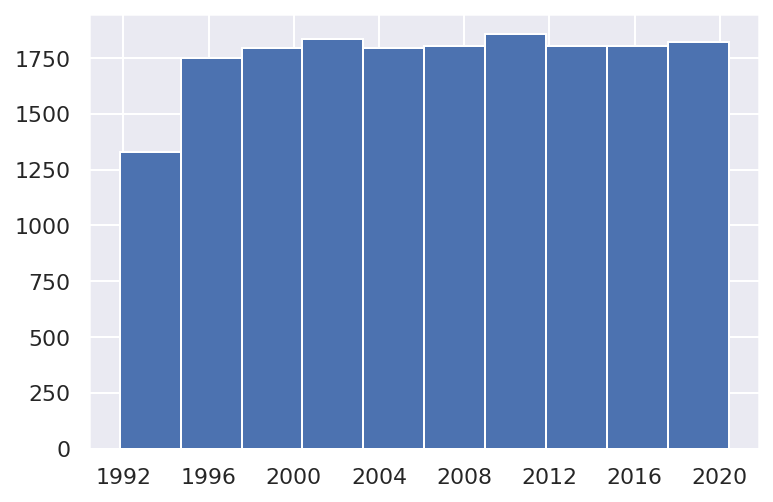

In [3]:
job_seekers.rptdate.hist();

**It started around 1992 and seems to have been regularly updated until now.**

Let's focus on last year. We'll keep only the job seekers report from 2019.

In [4]:
job_seekers_2019 = job_seekers[
    (job_seekers.rptdate > '2018-12-31') & (job_seekers.rptdate < '2020-01-01')].loc[
    :, '11-0000':'state']
mean_job_seekers_2019 = job_seekers_2019.groupby('state').mean().transpose()\
    .reset_index()
mean_job_seekers_2019['occupation_name'] = mean_job_seekers_2019\
    ['index'].map(iud_data_map.set_index('SOC').Occupation)
mean_job_seekers_2019[['occupation_name', 'Alabama', 'Texas']].head(10)

state,occupation_name,Alabama,Texas
0,Management,1289.583333,12461.166667
1,Business and Financial Operations,560.500000,7199.416667
2,Computer and Math,208.250000,3405.916667
3,Architecture and Engineering,206.916667,1780.583333
4,"Life, Physical and Social Sciences",65.500000,251.583333
5,Community and Social Services,151.583333,969.500000
6,Legal,51.333333,783.583333
7,"Education, Training and Library",376.500000,2181.583333
8,"Arts, Design, Entertainment Sport and Media",156.000000,1238.833333
9,Healthcare Practitioner and Technical,361.416667,1947.500000


Good! We now have an idea of how many people working in management (and other occupations) claimed for unemployment insurance last year in each state.

Do we have data for every states and occupations?

In [5]:
display(mean_job_seekers_2019.min().value_counts().head().to_frame())
print('Are there states with no job seekers in any occupation?')
display((mean_job_seekers_2019.max() == 0).any())
print('Are there occupations with no job seekers in any state?')
(mean_job_seekers_2019.max(axis='columns') == 0).any()

,0
0.000000,11
3.666667,3
43.750000,2
20.916667,1
15.750000,1


Are there states with no job seekers in any occupation?


False

Are there occupations with no job seekers in any state?


False

11 states out of 50 had at least one occupation with no job seekers claiming for insurance. 
**No job state or occupation is totally empty.**

What is the distribution of job seekers accross occupations in each state?

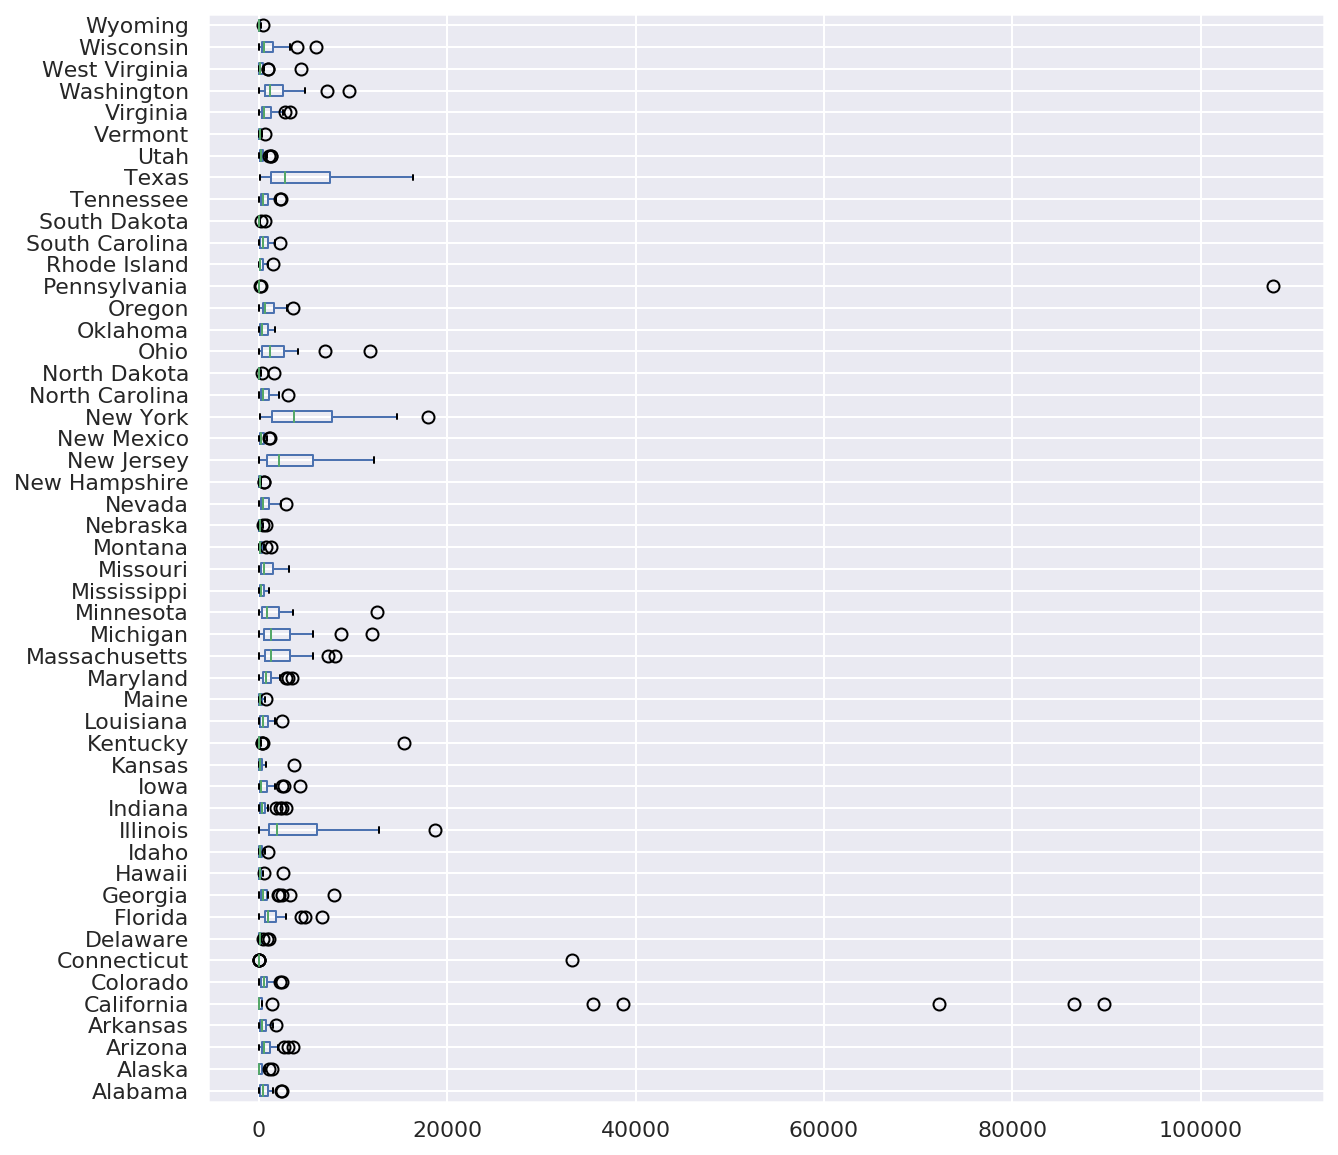

In [6]:
mean_job_seekers_2019.boxplot(figsize=(10, 10), vert=False);

There are some outliers.

Let's ignore them for now.

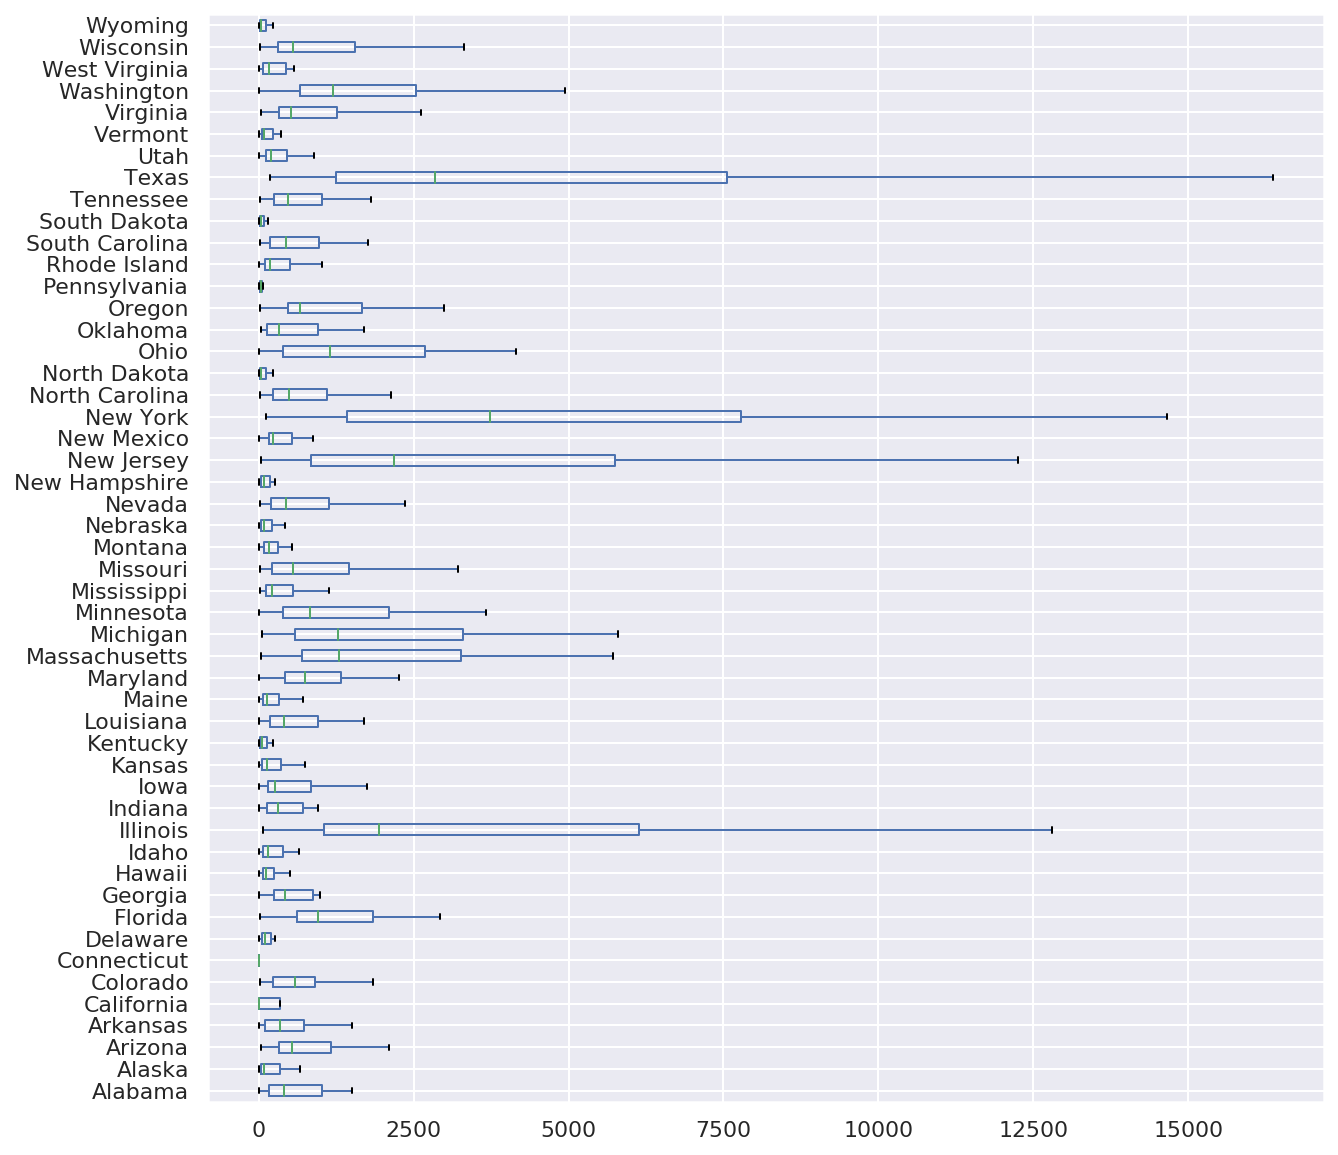

In [7]:
mean_job_seekers_2019.boxplot(
    figsize=(10, 10), showfliers=False, vert=False);

Oh! some states have lot less job seekers claiming for insurance than others. Is it related to the number of people living there? Yes for some of [them](https://www.infoplease.com/us/states/state-population-by-rank) (Vermont, Wyoming) but not for California. Some states seem to have a huge variance between occupations.

What about the occupations? Are they following the same trend accross states?

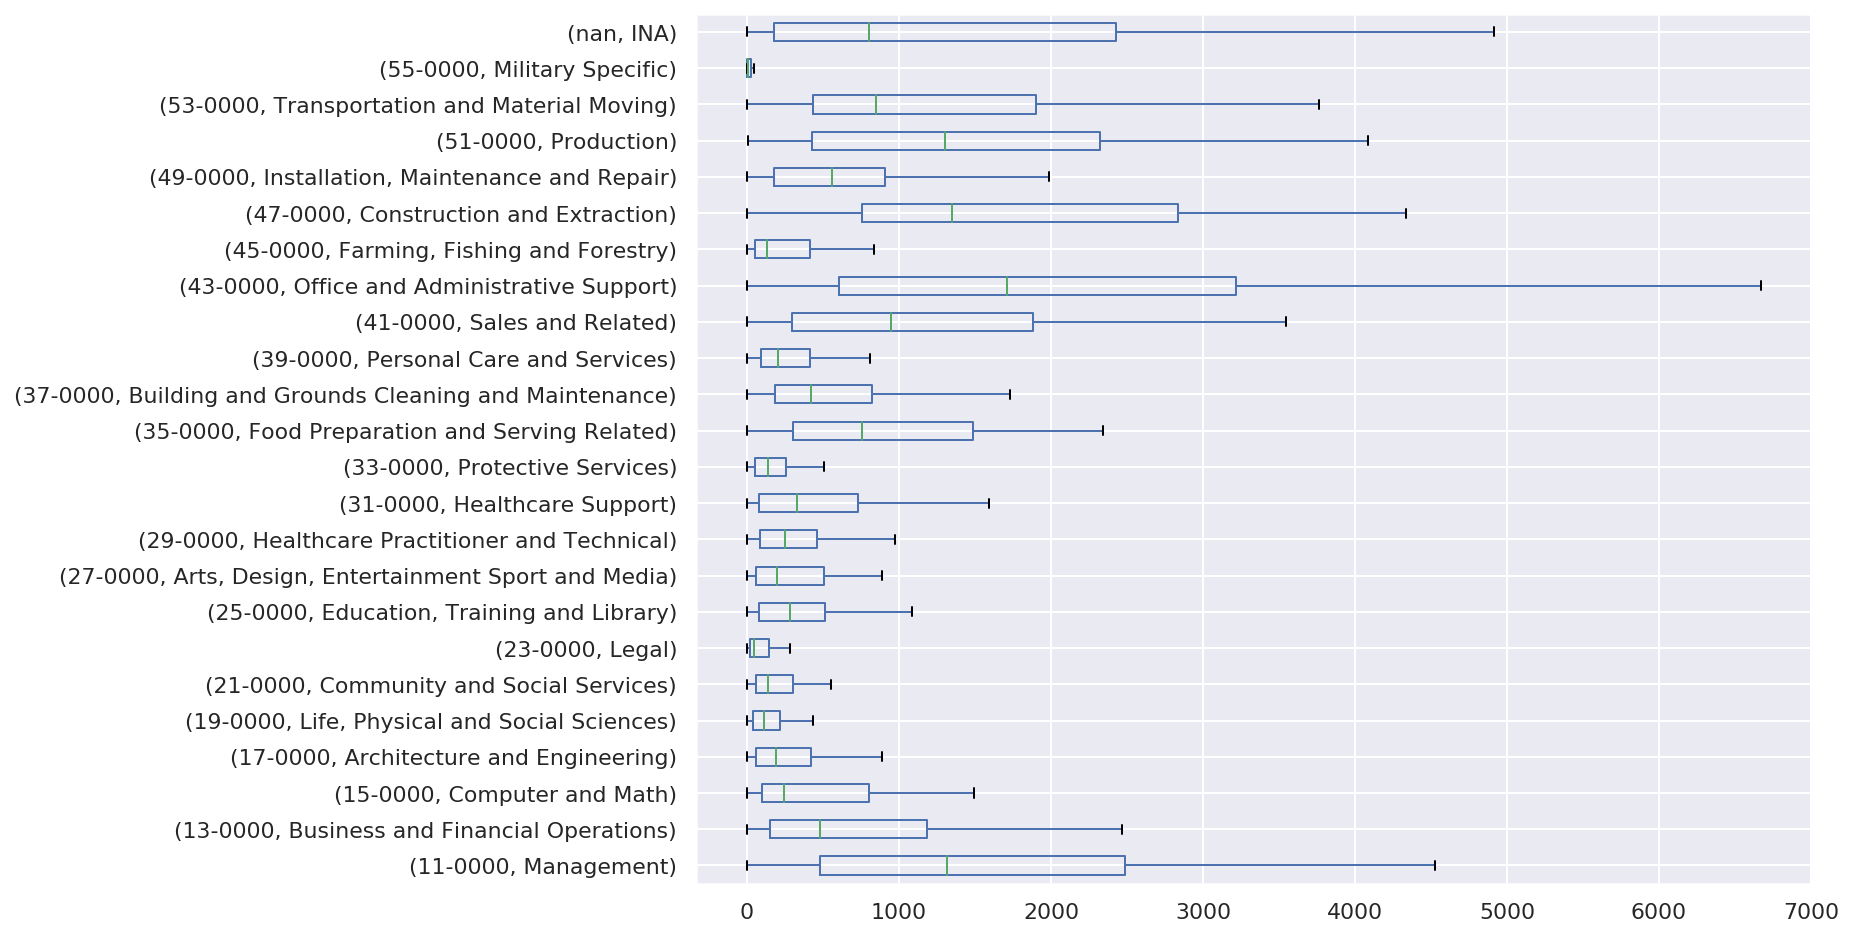

In [8]:
mean_job_seekers_2019.set_index(['index', 'occupation_name'])\
    .T.boxplot(figsize=(10, 8), showfliers=False, vert=False);

Some occupations don't vary a lot accross states. Probably related to the number of job seekers for each occupation and the breadth of the occupation groups.

## Occupations

Note that these are the [May 2019 estimates](https://www.bls.gov/oes/current/oes_tec.htm).

What's going on at the occupation level? We are interested in the total number of employees.

In [9]:
occupations[['area_title', 'tot_emp', 'occ_title', 'loc_quotient']]

,area_title,tot_emp,occ_title,loc_quotient
0,Alabama,1974170,All Occupations,1
1,Alabama,83760,Management Occupations,0.77
2,Alabama,1320,Chief Executives,0.48
3,Alabama,30790,General and Operations Managers,0.95
4,Alabama,1110,Legislators,1.58
...,...,...,...,...
36377,Virgin Islands,40,Crane and Tower Operators,3.47
36378,Virgin Islands,60,Industrial Truck and Tractor Operators,0.4
36379,Virgin Islands,470,"Laborers and Freight, Stock, and Material Move...",0.68
36380,Virgin Islands,120,"Packers and Packagers, Hand",0.82


Not much to say! 

We've noticed missing values earlier. Are there any for the total number of employees? 
We'll focus on the same occupation groups than before.

In [10]:
occupations['tot_emp_format'] = pd.to_numeric(
    occupations.tot_emp, errors='coerce')
occupations.tot_emp_format.isna().sum() / occupations.tot_emp_format.count() * 100

4.389991966027774

Less than 5%, and that's a good thing.

**Does the occupation distribution looks the same than the job seekers'?**

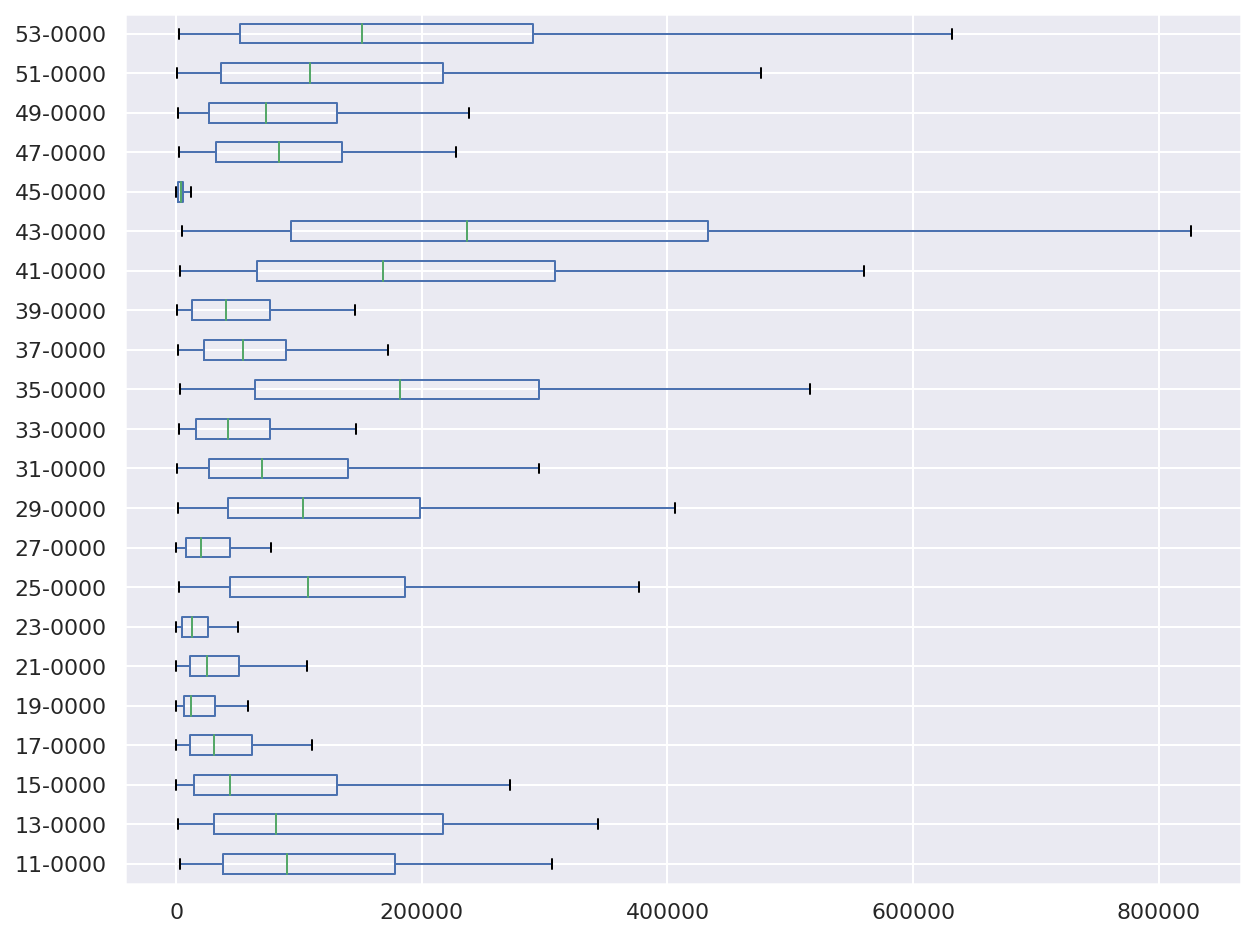

In [11]:
occupations_pivot = occupations[occupations.o_group == 'major'].pivot(
    index='area_title', columns='occ_code', values='tot_emp_format')
occupations_pivot.boxplot(figsize=(10, 8), showfliers=False, vert=False);

**Yep! They are quite similar. That makes sense**

**What about the distribution accross states?**

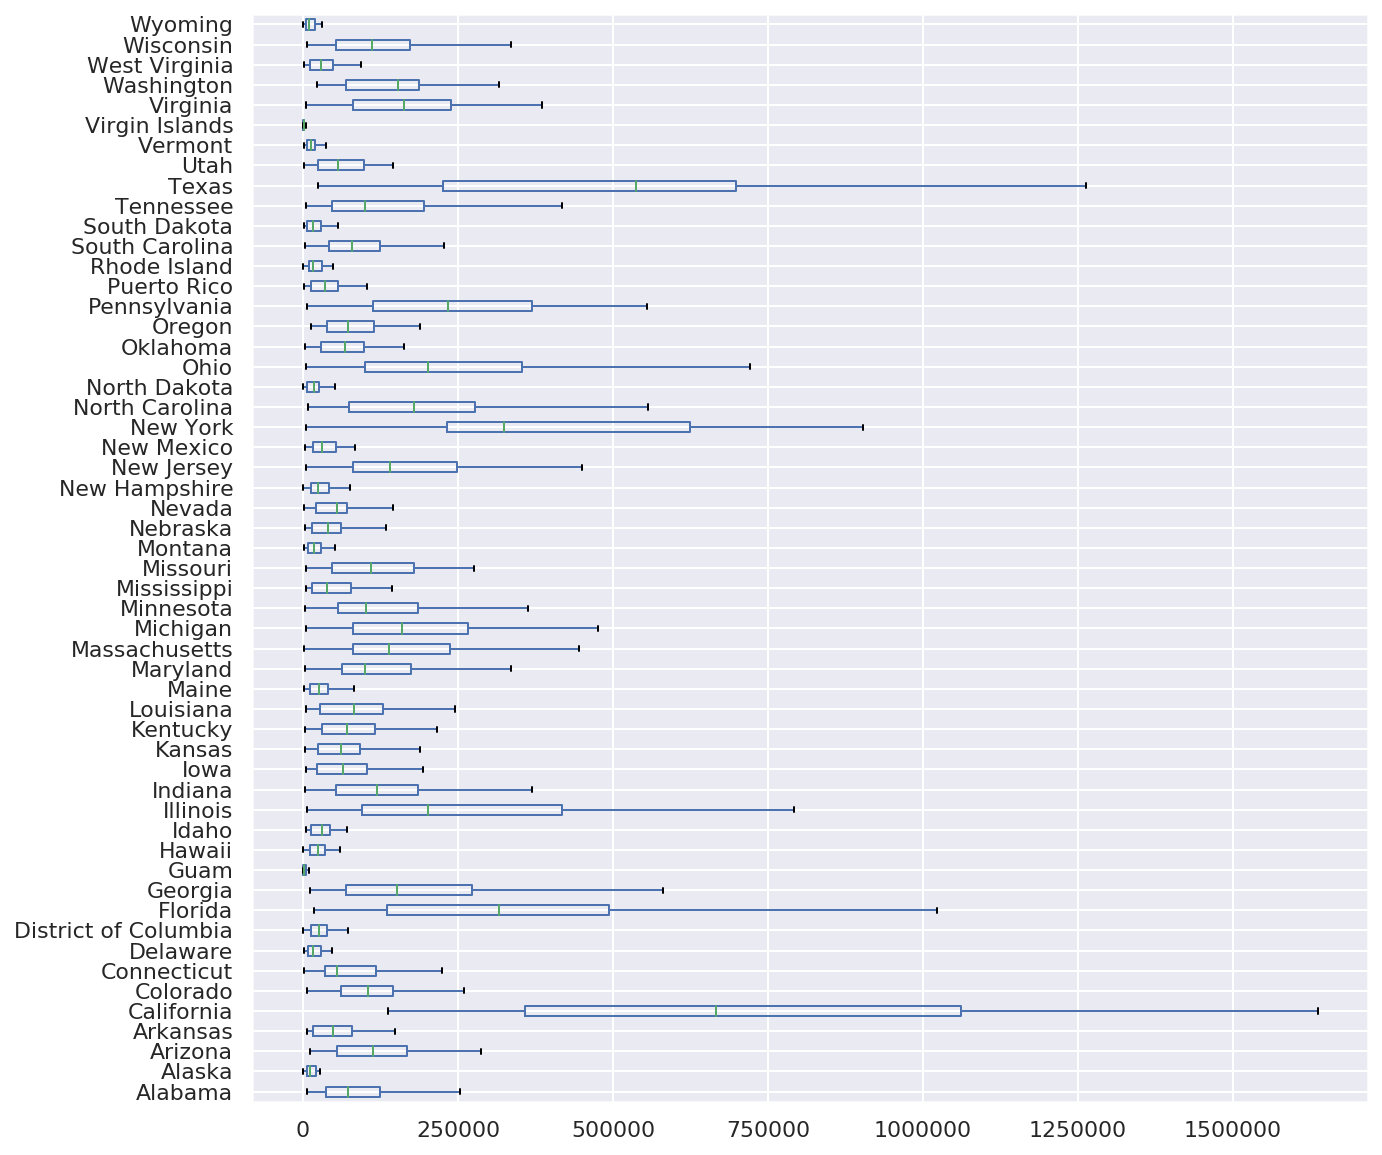

In [12]:
occupations_pivot.T.boxplot(figsize=(10, 10), showfliers=False, vert=False);

Interestingly, some states with a big populations that seemed under-represented in terms of job seekers (e.g Califormia, Pennsylvania) appear to have a reasonable amount of people employed.

### Employment projections

As seen before, employment projections use 2019 as a base year. And it's the year the most useful to us.

Hmm, let's check that the base year is really a single year.

In [13]:
projections['Base Year'].unique()

array([2019])

OK! No surprise.

What about the projected year?

In [14]:
projections['Projected Year'].unique()

array([2021])

OK!

As opposed to the other datasets, the projections' dataset seems to lack info for major occupation groups. 
Let's check this.

In [15]:
projections[projections['Occupation Code'] == '11-1000']

,State FIPS,Area Name,Occupation Code,Occupation Name,Base Year,Base,Projected Year,Projection,Change,Percent Change,Average Annual Openings


Nope!

Time for some action, then.

In [16]:
projections['SOC_major'] = projections['Occupation Code'].\
    str.replace('\d{4}', '0000', regex=True)
projections.head()

,State FIPS,Area Name,Occupation Code,Occupation Name,Base Year,Base,Projected Year,Projection,Change,Percent Change,Average Annual Openings,SOC_major
0,1,Alabama,00-0000,"Total, All Occupations",2019,2198090,2021,2252990,54900,2.5,284240,00-0000
1,1,Alabama,11-1011,Chief Executives,2019,1910,2021,1920,10,0.5,140,11-0000
2,1,Alabama,11-1021,General and Operations Managers,2019,29040,2021,30000,960,3.3,3040,11-0000
3,1,Alabama,11-1031,Legislators,2019,1270,2021,1290,20,1.6,110,11-0000
4,1,Alabama,11-2011,Advertising and Promotions Managers,2019,70,2021,70,0,0.0,10,11-0000


We did it!

Now let's sum the detailed groups into major groups.

In [17]:
projections_pivot = pd.pivot_table(
    projections, index='Area Name', columns='SOC_major',
    values='Base', aggfunc=sum).drop(columns=['00-0000'])
projections_pivot.head()

SOC_major,11-0000,13-0000,15-0000,17-0000,19-0000,21-0000,23-0000,25-0000,27-0000,29-0000,...,35-0000,37-0000,39-0000,41-0000,43-0000,45-0000,47-0000,49-0000,51-0000,53-0000
Area Name,,,,,,,,,,,,,,,,,,,,,
Alabama,113410.0,80180.0,43130.0,45920.0,9060.0,33810.0,11550.0,111610.0,26540.0,139570.0,...,169070.0,80180.0,63540.0,228520.0,312000.0,34600.0,90150.0,102190.0,221080.0,161830.0
Alaska,19650.0,12080.0,4340.0,7140.0,6160.0,5990.0,1950.0,18800.0,3210.0,17020.0,...,27300.0,12160.0,13570.0,29480.0,51030.0,1790.0,21090.0,15860.0,14180.0,26080.0
Arizona,220010.0,163150.0,100930.0,56370.0,20090.0,46150.0,23020.0,140400.0,46640.0,174720.0,...,275520.0,102690.0,141900.0,311940.0,493550.0,26320.0,156420.0,124200.0,120670.0,183740.0
Arkansas,130780.0,58250.0,24610.0,12830.0,6810.0,31500.0,7640.0,80430.0,13150.0,84290.0,...,107220.0,45190.0,45770.0,133960.0,181300.0,16800.0,50560.0,60580.0,119370.0,107680.0
California,1297600.0,1130900.0,669400.0,362100.0,198600.0,324900.0,163800.0,1113600.0,450000.0,884000.0,...,1632000.0,586100.0,1175300.0,1752400.0,2568100.0,388300.0,837600.0,583700.0,866000.0,1224900.0


Brilliant!

As before, what is the occupation distribution?

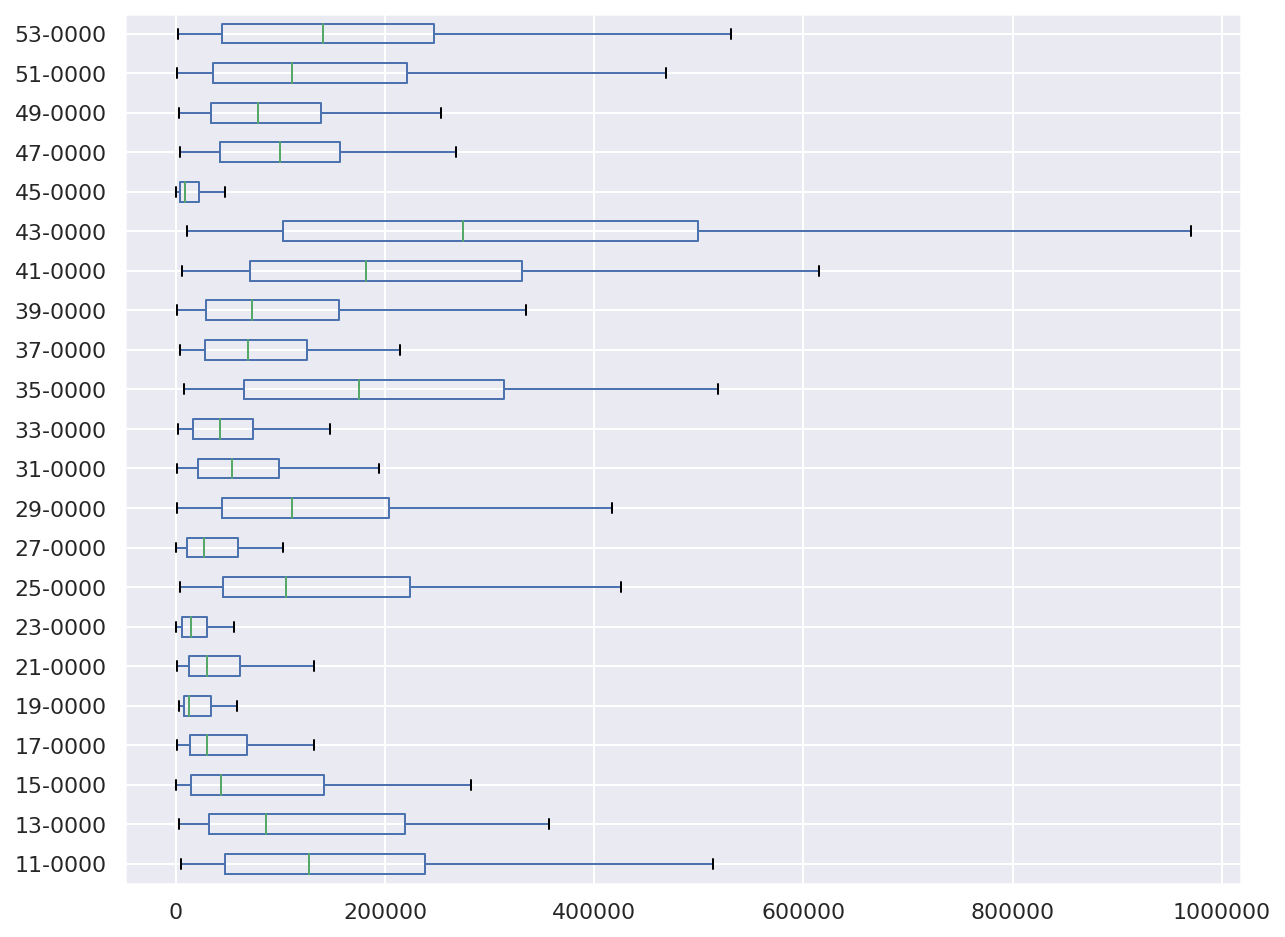

In [18]:
projections_pivot.boxplot(figsize=(10, 8), showfliers=False, vert=False);

This is still consistent with the two others.

What about the states?

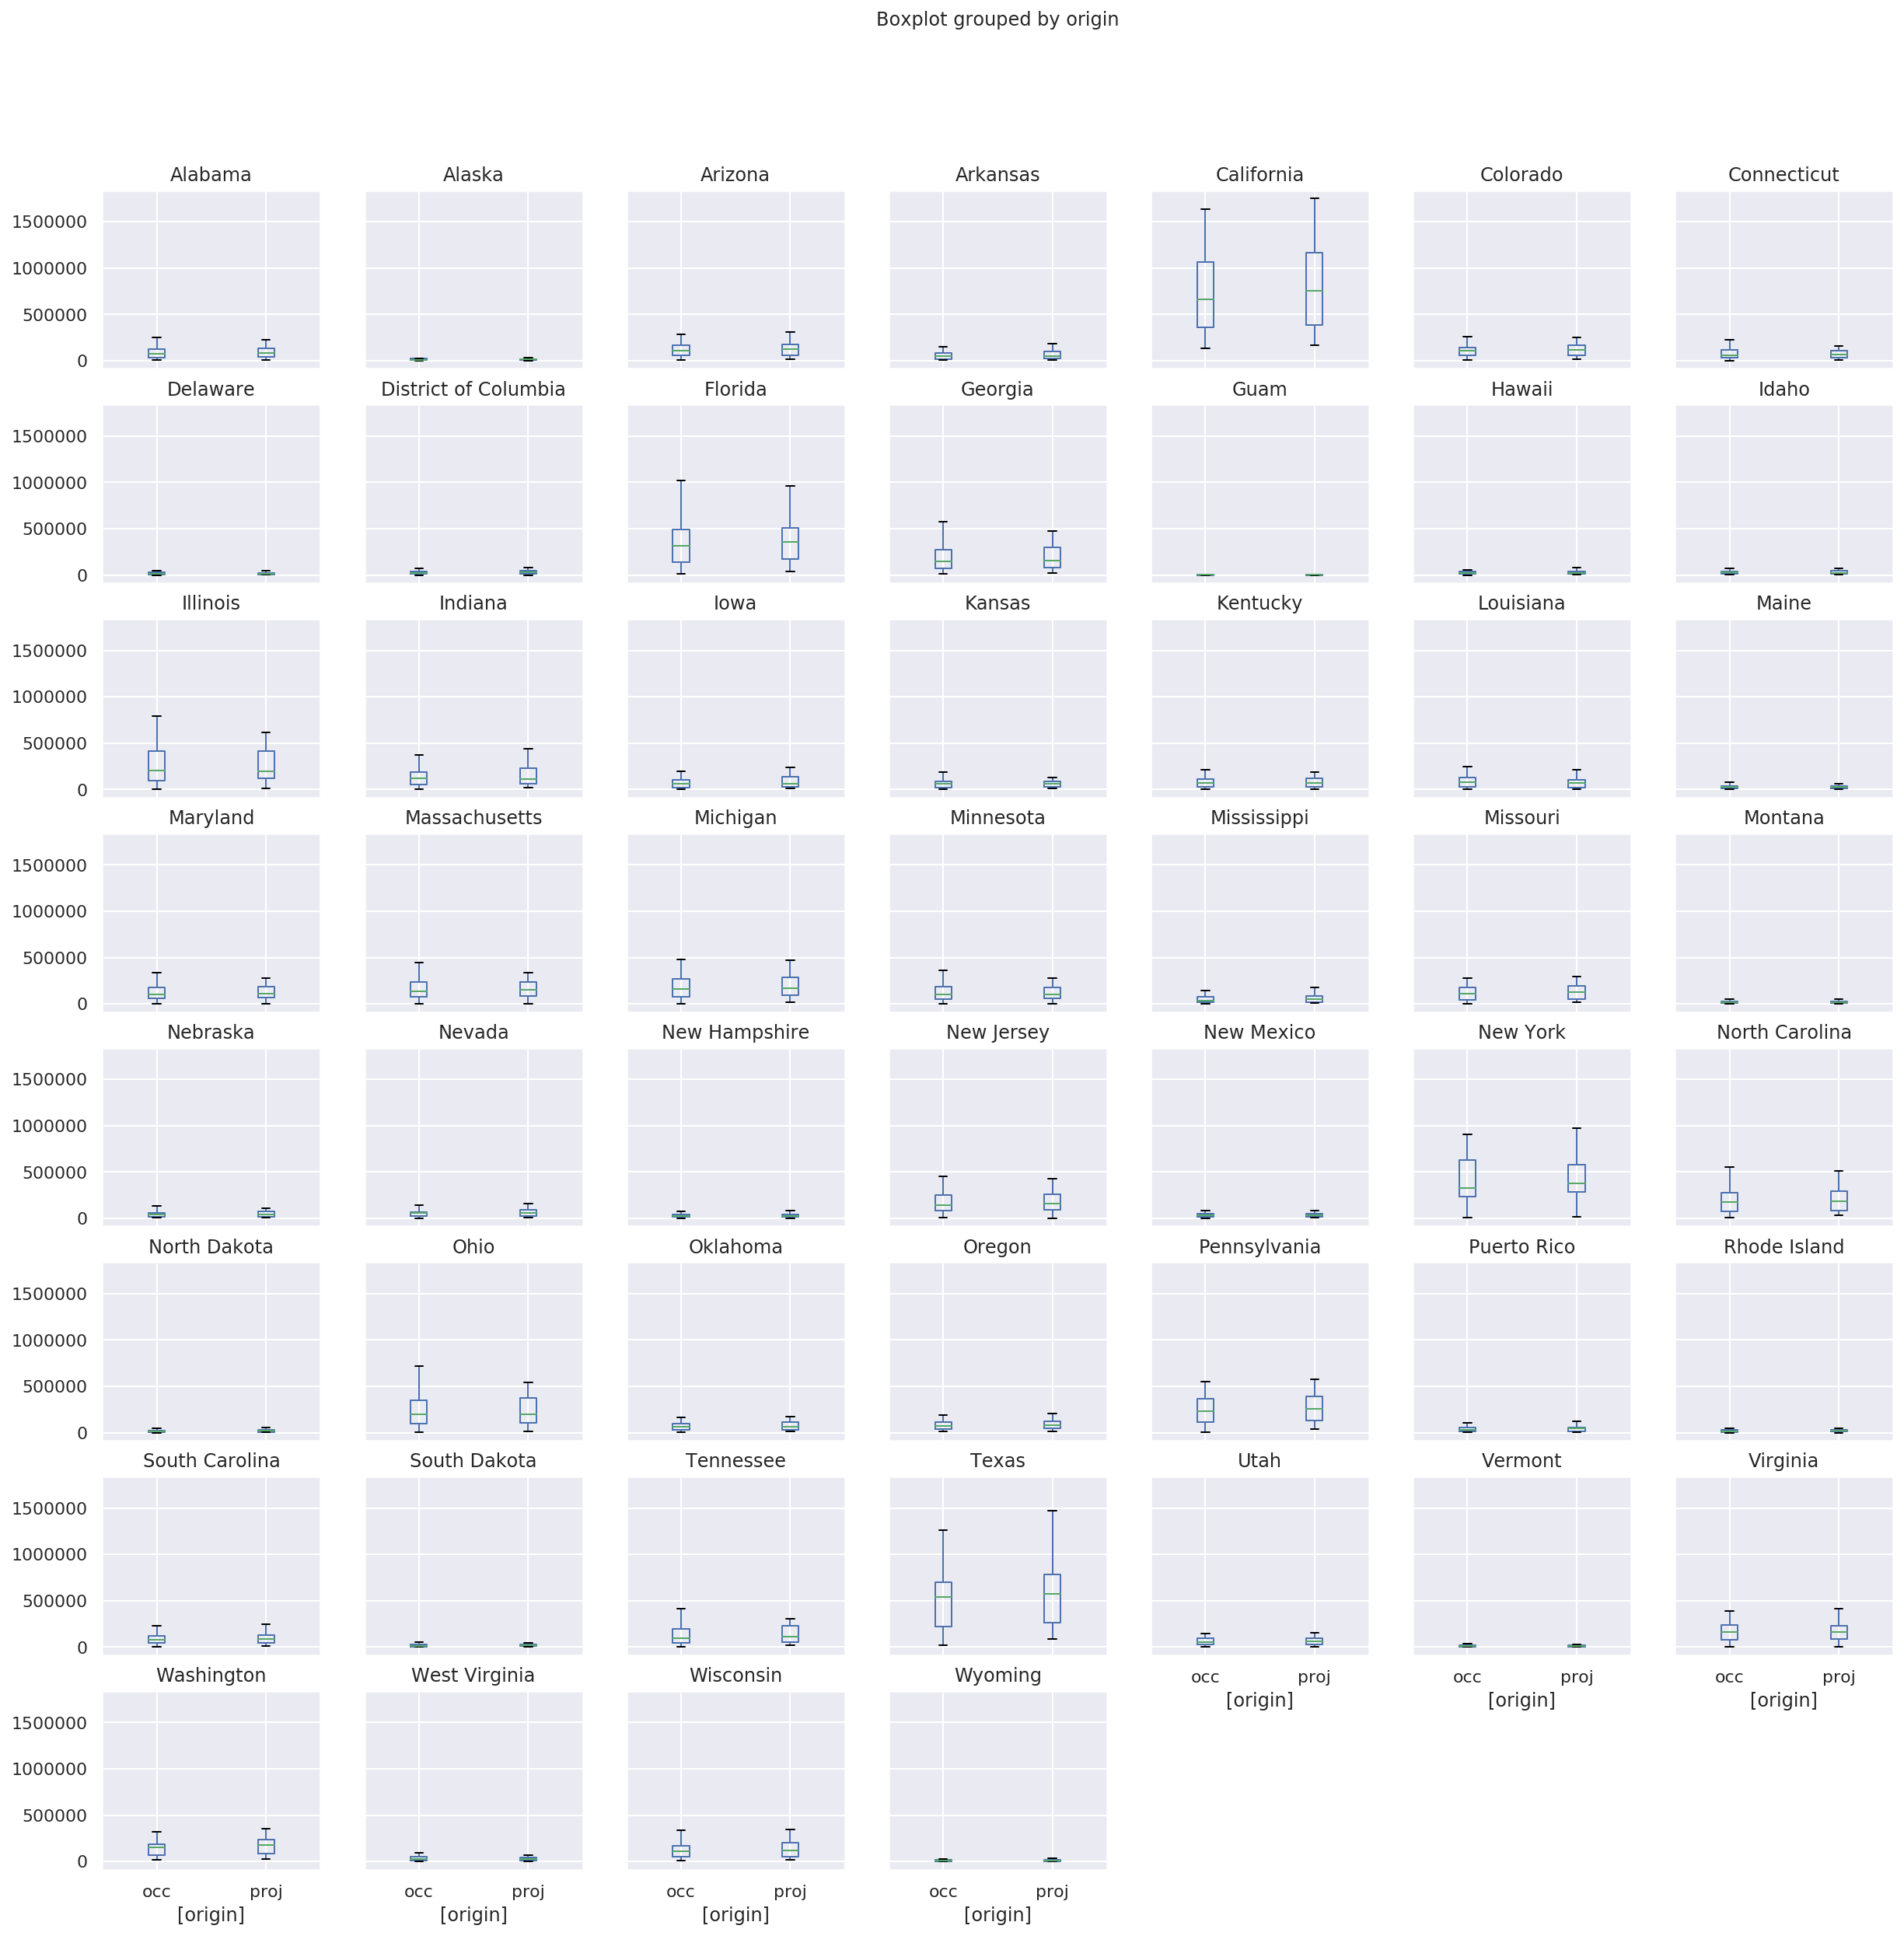

In [19]:
# The list of states differs between the datasets. We'll make sure
# that it is the same before plotting.
occ_temp = occupations_pivot.drop(index=['Virgin Islands']).T\
    .assign(origin='occ')
proj_temp = projections_pivot.T.assign(origin='proj')
occ_proj = pd.concat([occ_temp, proj_temp])
occ_proj.boxplot(by='origin', figsize=(20, 20), showfliers=False);

Sounds quite similar to the occupation data.
- Occupation and projection data seem comparable and that's good if we want to deduce the job vacancies from them.
- The job seekers dataset looks biased with data probably missing for big states such as California.

## Market stress computation

We want to compute job vacancies / job seekers.  
Let's compute job vacancies first (estimates of the total number of jobs - occupied jobs).

In [20]:
vacancies = projections_pivot - occupations_pivot.drop(
    index=['Virgin Islands'])
    
vacancies.head()

SOC_major,11-0000,13-0000,15-0000,17-0000,19-0000,21-0000,23-0000,25-0000,27-0000,29-0000,...,35-0000,37-0000,39-0000,41-0000,43-0000,45-0000,47-0000,49-0000,51-0000,53-0000
Area Name,,,,,,,,,,,,,,,,,,,,,
Alabama,29650.0,1580.0,-940.0,1440.0,-1680.0,14160.0,590.0,6370.0,8300.0,9880.0,...,-17830.0,24460.0,29280.0,19790.0,58500.0,28630.0,7110.0,3690.0,1800.0,-8290.0
Alaska,-2030.0,-480.0,-710.0,-690.0,-220.0,-600.0,-190.0,-2900.0,-120.0,-510.0,...,-170.0,3020.0,5940.0,3800.0,4800.0,1200.0,2520.0,-2320.0,4370.0,-740.0
Arizona,50700.0,-3040.0,3010.0,4640.0,390.0,-1530.0,2460.0,-6140.0,14480.0,7130.0,...,6720.0,18680.0,77580.0,25260.0,55220.0,14370.0,20100.0,7170.0,12150.0,-43940.0
Arkansas,65350.0,5140.0,2280.0,280.0,90.0,16890.0,1330.0,2720.0,4090.0,3750.0,...,-2790.0,11260.0,25840.0,12360.0,32290.0,10970.0,5660.0,2540.0,1680.0,-21240.0
California,227480.0,77930.0,25100.0,17430.0,16240.0,21030.0,26250.0,49190.0,122160.0,39070.0,...,4510.0,97140.0,773430.0,115820.0,413400.0,154250.0,148940.0,45580.0,29220.0,-228300.0


Oh no!!! Negative values! **So there are markets for which the total number of jobs estimates are lower than the total number of occupied jobs.** So no vacancies and more than that more jobs occupied than jobs.

Let's have a look to how bad it is before aborting the mission.

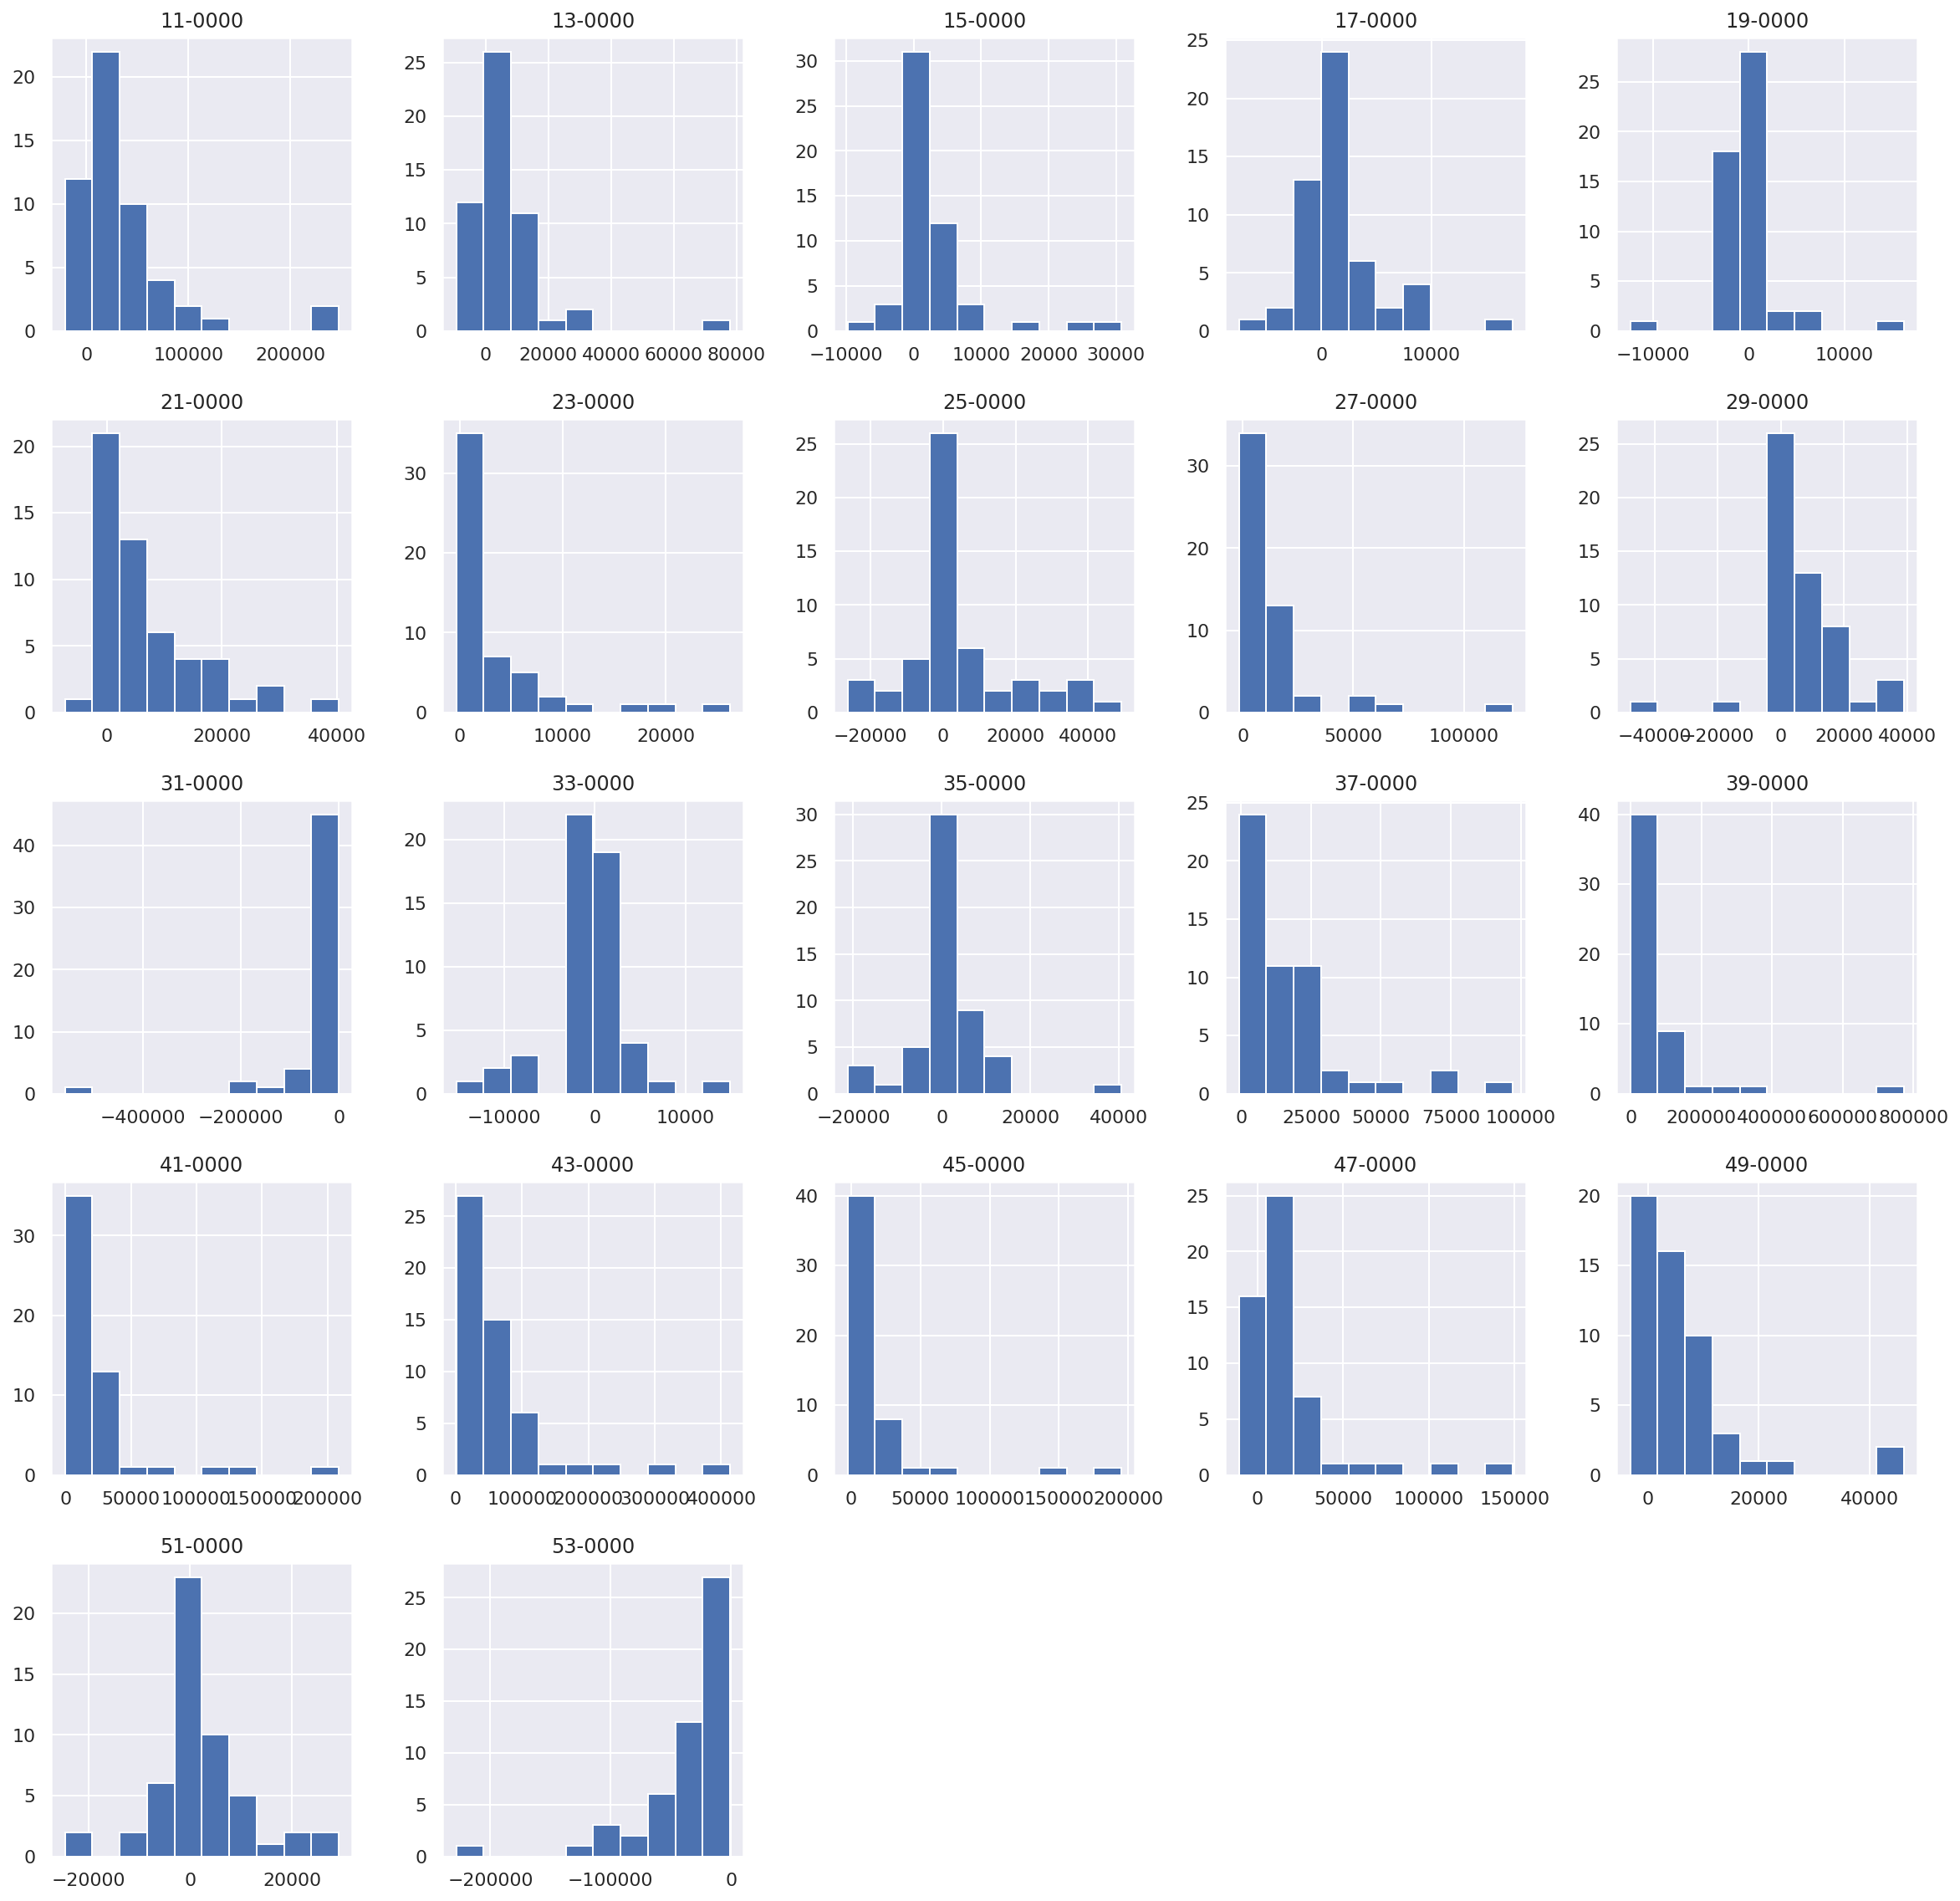

In [21]:
vacancies.hist(figsize=(20, 20));

There are occupations with no or very few total job estimates (e.g. 31-0000: Healthcare Support Occupations, 53-0000: Transportation and Material Moving Occupations).

A little glimpse on the states.

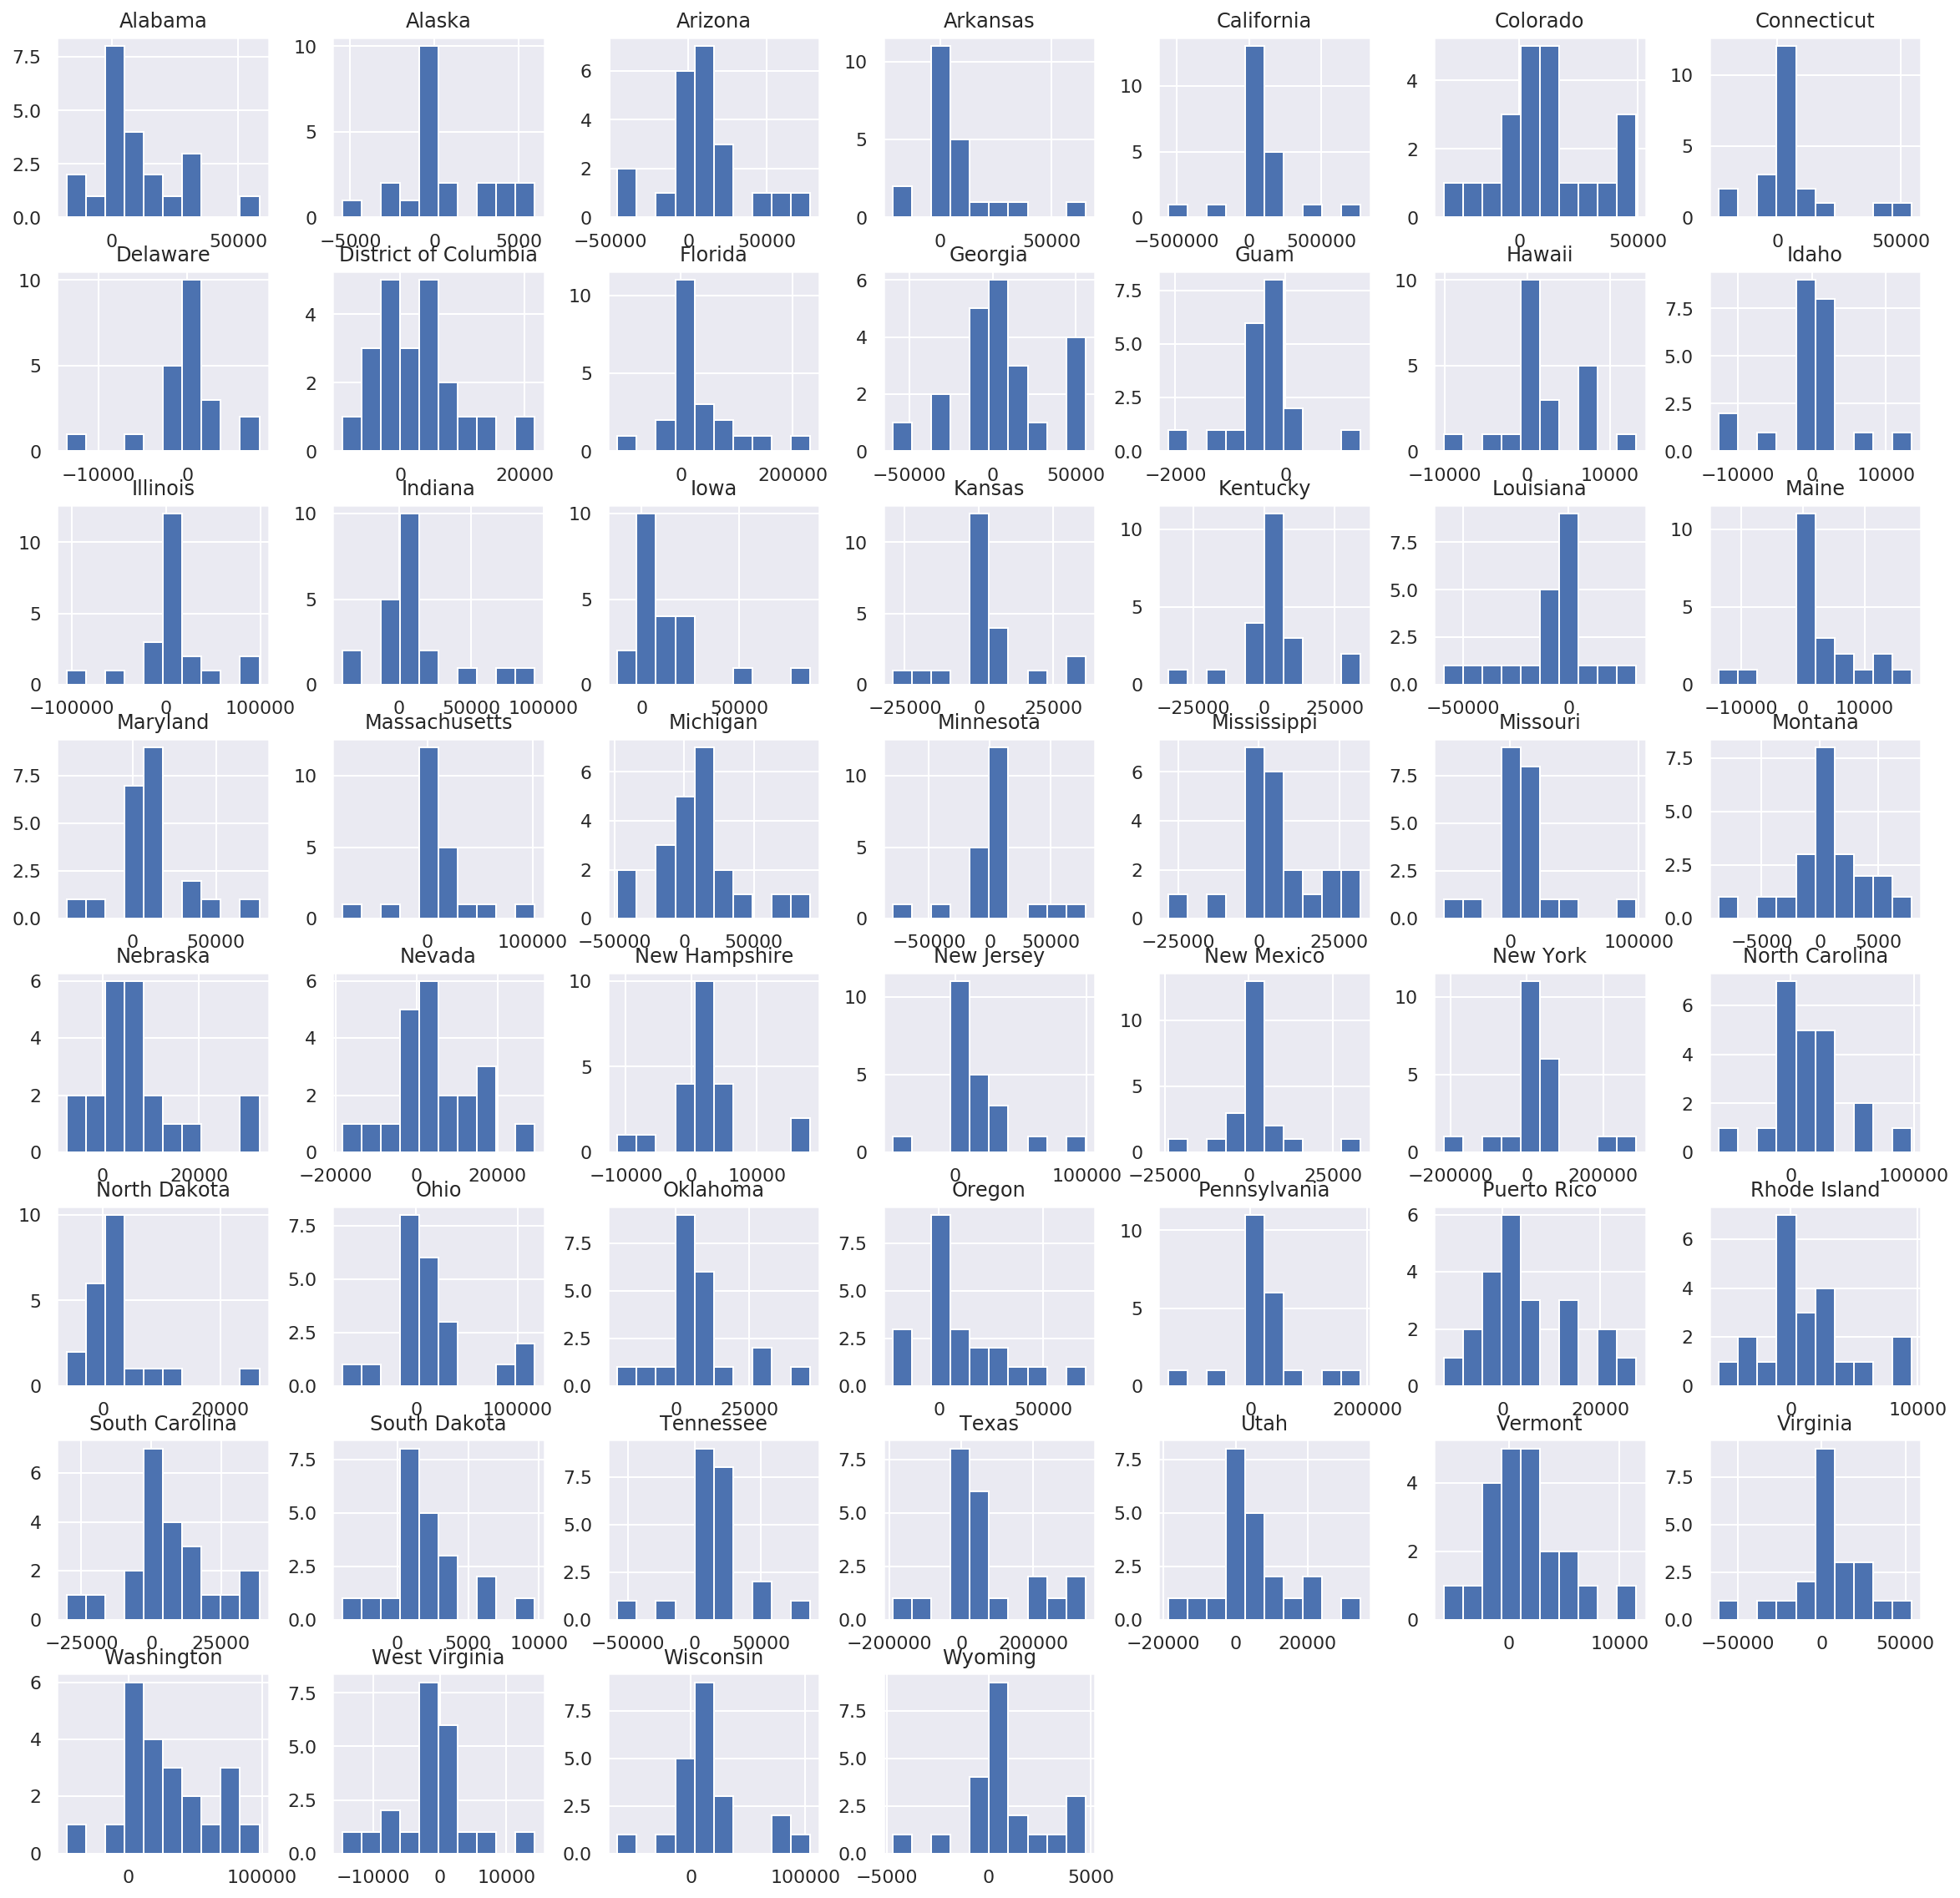

In [22]:
vacancies.T.hist(figsize=(20, 20));

Several states have a large amount of occupations with no or negative vacancies (Vermont, Michigan).


## Conclusions

Green Flags:  
- Occupational and projections dataset seem comparable. Maybe too comparable!

Red flags:  
- It looks like there is a data collection timing issues as we have a lot of negative vacancies (total number of jobs estimates is lower than the occupied jobs of the same year).
- The job seekers dataset has weird numbers for some states (e.g California).

Final flag:  
Abort! Abort! Abort!